# RdTools

In [1]:
import utils
import pandas as pd

from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.transform import jitter
from bokeh.io import output_notebook

In [2]:
output_notebook()

Loading BokehJS ...

## ReadTheDocs

In [3]:
df = utils.get_rtd_analytics_data('rdtools')
data_period = df['Date'].min().strftime('%Y-%m-%d') + ' to ' + df['Date'].max().strftime('%Y-%m-%d')

In [4]:
total_by_version = df.groupby('Version')['Views'].sum().reset_index()

p = figure(x_range=total_by_version['Version'], height=350, tooltips=[("Version", "@Version"), ("Views", "@Views")],
           title=f"Page views by RTD version ({data_period})",)
p.vbar(x='Version', top='Views', width=0.75, source=total_by_version,
       line_color='white')
p.xaxis.major_label_orientation = 3.14/2
p.yaxis.axis_label = 'Total page views'
show(p)

In [5]:
daily_views = df.pivot_table(values='Views', index='Date', columns='Version', aggfunc='sum')[['stable', 'latest']].fillna(0)

p = figure(x_axis_type="datetime", height=350, title=f"Daily views by RTD version")
hover_tool = HoverTool(tooltips=[('Date', '@x{%Y-%m-%d}'), ('Views', '@y')],
                       formatters={'@x': 'datetime'})
hover_tool.point_policy = 'snap_to_data'
p.add_tools(hover_tool)
p.line(daily_views.index, daily_views['stable'], legend_label='stable')
p.line(daily_views.index, daily_views['latest'], legend_label='latest', color='#ff7f0e')
p.yaxis.axis_label = 'Daily page views'
show(p)

In [6]:
annual = df.loc[df['Version'] == 'stable', ['Date', 'Views']].set_index('Date')['Views'].resample('a').sum()
views = pd.DataFrame({'year': annual.index.year, 'views': annual})

p = figure(height=350, tooltips=[("Annual page views", "@views"), ("Year", "@year")],
           title="Annual page views")
p.vbar(x='year', top='views', width=0.75, source=views)
p.yaxis.axis_label = 'Annual page views'
show(p)

In [7]:
df2 = df.loc[(df['Version'] == 'stable'), :].copy()
pathviews = df2.groupby('Path')['Views'].sum().reset_index()

In [8]:
n = 20
subset = pathviews.sort_values('Views', ascending=False)[:n]
p = figure(y_range=subset['Path'], height=400, width=700, tooltips=[("URL", "@Path"), ("Views", "@Views")],
           title=f"Views by URL (Top {n}, {data_period})")
p.hbar(y='Path', right='Views', source=subset, height=0.75,
       line_color='white')
p.xaxis.axis_label = 'Total page views'
show(p)

In [9]:
df2['Quarter'] = utils.fyq_format(df2['Date'])
last_quarter = 'Q1FY23'  # TODO: calculate last quarter dynamically
df3 = df2.loc[df2['Quarter'] == last_quarter, :]
pathviews_last_quarter = df3.groupby('Path')['Views'].sum().reset_index()

In [10]:
n = 20
subset = pathviews_last_quarter.sort_values('Views', ascending=False)[:n]
p = figure(y_range=subset['Path'], height=400, width=700, tooltips=[("URL", "@Path"), ("Views", "@Views")],
           title=f"Views by URL (Top {n}, {last_quarter})")
p.hbar(y='Path', right='Views', source=subset, height=0.75,
       line_color='white')
p.xaxis.axis_label = 'Total page views'
show(p)

In [11]:
df4 = df2.loc[df2['Quarter'].isin(['Q4FY22', 'Q1FY23']), :]
pathviews_last_two_quarters = df4.groupby('Path')['Views'].sum().reset_index()
n = 20
subset = pathviews_last_two_quarters.sort_values('Views', ascending=False)[:n]
p = figure(y_range=subset['Path'], height=400, width=700, tooltips=[("URL", "@Path"), ("Views", "@Views")],
           title=f"Views by URL (Top {n}, Q4FY22–Q1FY23)")
p.hbar(y='Path', right='Views', source=subset, height=0.75,
       line_color='white')
p.xaxis.axis_label = 'Total page views'
show(p)

In [12]:
prefixes = ['examples', 'generated']
pathviews['Prefix'] = pathviews['Path'].str.split("/").str[1]
groupviews = pathviews.loc[pathviews['Prefix'].isin(prefixes), :].groupby('Prefix')['Views'].sum().loc[prefixes].sort_values().reset_index()

p = figure(x_range=groupviews['Prefix'], height=350, tooltips=[("Section", "@Prefix"), ("Views", "@Views")],
           title=f"Page views by docs section ({data_period})")
p.vbar(x='Prefix', top='Views', width=0.5, source=groupviews)
p.yaxis.axis_label = 'Total page views'
show(p)

In [13]:
subset = pathviews.loc[pathviews['Prefix'].isin(prefixes), :]

p = figure(x_range=prefixes, height=350, tooltips=[("URL", "@Path"), ("Views", "@Views")],
           title=f"Page views by docs page ({data_period})")
p.scatter(x=jitter('Prefix', width=0.1, range=p.x_range, distribution='normal'),
          y='Views', source=subset)
p.yaxis.axis_label = 'Total page views'
show(p)

In [14]:
for prefix in prefixes:
    subset = pathviews.loc[pathviews['Prefix'] == prefix, :]
    subset = subset.loc[~subset['Path'].str.endswith('/index.html'), :]
    subset = subset.sort_values('Views', ascending=False)[:n]
    subset['Path_Clean'] = subset['Path'].str.replace('^/'+prefix+'/', '', regex=True)

    extra = f"Top {n}, " if len(subset) == n else ''
    p = figure(y_range=subset['Path_Clean'], width=700, height=400, tooltips=[("URL", "@Path"), ("Views", "@Views")],
               title=f"{prefix} ({extra}{data_period})")
    p.hbar(y='Path_Clean', right='Views', source=subset, height=0.75,
           line_color='white')
    p.xaxis.axis_label = 'Total page views'
    show(p)

In [15]:
quarterly_views = df2.set_index('Date').resample('Q')[['Views']].sum()
quarterly_views['Quarter'] = utils.fyq_format(quarterly_views.index.to_series())

p = figure(x_range=quarterly_views['Quarter'], height=300, tooltips=[("Quarter", "@Quarter"), ("Total Views", "@Views")],
           title=f"Total page views by Quarter ({data_period})",)
p.vbar(x='Quarter', top='Views', width=0.75, source=quarterly_views,
       line_color='white')
#p.xaxis.major_label_orientation = 3.14/2
p.yaxis.axis_label = 'Total page views'
show(p)

## GitHub

In [16]:
gh = utils.get_github_stars('nrel/rdtools')

In [17]:
p = utils.plot_github_stars_timeseries(gh)
show(p)

In [18]:
forks = utils.get_github_forks('nrel/rdtools')
forks = pd.DataFrame({'year': forks.index.year, 'forks': forks})

In [19]:
p = figure(height=350, tooltips=[("Cumulative forks", "@forks"), ("Year", "@year")],
           title="Cumulative forks")
p.vbar(x='year', top='forks', width=0.75, source=forks)
p.yaxis.axis_label = 'Total forks'
show(p)

In [20]:
prs = utils.get_github_pull_requests('nrel/rdtools')
prs = pd.DataFrame({'year': prs.index.year, 'prs': prs})

In [21]:
p = figure(height=350, tooltips=[("Cumulative PRs", "@prs"), ("Year", "@year")],
           title="Cumulative PRs")
p.vbar(x='year', top='prs', width=0.75, source=prs)
p.yaxis.axis_label = 'Total PRs'
show(p)

In [22]:
contributor_ts, _ = utils.get_github_contributor_timeseries("nrel/rdtools")

In [23]:
p = utils.plot_github_contributors_timeseries(contributor_ts)
show(p)

In [24]:
contributors = utils.get_github_contributors('nrel/rdtools')

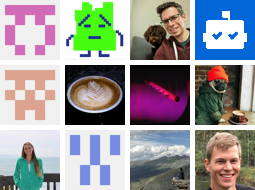

In [25]:
mosaic = utils.make_github_contributors_mosaic(contributors, n_wide=4, n_high=3)
mosaic